# Graph learning from data

* Using a scipy.optimize.minimize routine to learn the graph structure using synthetic data, this is based on one of the methods discussed in arxiv:1601.02513
* $ min \ \ \ tr(X^{T}LX) +\alpha ||L||_{F}$

In [1]:
import h5py
import numpy as np
from minimizer import *
import matplotlib.pyplot as plt

* Specify number of sensors and alpha (1t = 127 sensors) top array only

In [2]:
n_sensors = 127

* Load Wfsim synthetic data for 1T detector config

In [4]:
#  Uses only 5 runs as an example
files = ['/data/xenon1t/wfsim_data/wfsim_data_run_id_1001.h5',
         '/data/xenon1t/wfsim_data/wfsim_data_run_id_1002.h5',
         '/data/xenon1t/wfsim_data/wfsim_data_run_id_1003.h5',
         '/data/xenon1t/wfsim_data/wfsim_data_run_id_1004.h5',
         '/data/xenon1t/wfsim_data/wfsim_data_run_id_1005.h5'
         
        ]

data = []
for i in range(0,len(files)):
    with h5py.File(files[i], "r") as f:# List all groups
        a_group_key = list(f.keys())[0]      
        data.append(np.array(f[a_group_key][:]))
        

In [5]:
data_all = np.concatenate(([data[i] for i in range(5)]))   

In [6]:
hp_all = data_all['area_per_channel']

* Use only top array

In [7]:
hp_top = np.delete(hp_all, np.arange(127,248), axis=1)

In [8]:
cov_m = np.cov(hp_top.T)

* For completeness plot the covariance matrix

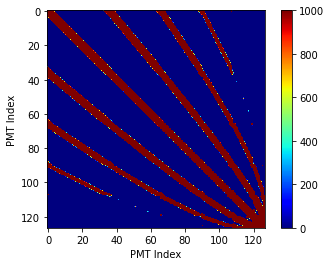

In [9]:
fig = plt.figure()
ax= fig.subplots()
plt.imshow(cov_m, cmap='jet',vmin=0,vmax=1e3)
plt.colorbar()
ax.set_ylabel('PMT Index')
ax.set_xlabel('PMT Index')
limits=plt.axis('on')
plt.show()

In [10]:
signal = hp_top

* Using trace's cyclic property we can calculate the product $X^{T}X$, where $S=X^{T}X$ 

In [11]:
S = (1.0/len(signal))*np.matmul(np.asarray(signal).T,np.asarray(signal))

* Use the identity matrix times 2 a $L_{0}$ (first guess)

In [12]:
L0 = np.identity(n_sensors)*2

In [13]:
L0

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

* Call minimization routine
* Input parameters:
    * number of sensors
    * alpha (a.k.a inverse of graph density)
    * S = $X^{T}X$

In [14]:
myMinimizer = Minimizer(n_sensors=n_sensors, alpha=0.33, S=S)

In [15]:
sol = myMinimizer.Optimization(L0=L0, maxiter=100)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   | 16130 |   0   | +3.2494e+07 | 1.00e+00 | 1.76e+05 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |


/home/ahiguera-mx/.local/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   2   | 32260 |   1   | +3.0152e+07 | 7.00e+00 | 1.75e+05 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   | 48390 |   2   | +9.4027e+06 | 4.90e+01 | 1.59e+05 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   4   | 64520 |   5   | +4.7026e+04 | 4.90e+01 | 4.35e+01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   5   | 80650 |   6   | +2.3507e+02 | 4.90e+01 | 1.01e-03 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   6   | 96780 |   7   | +1.1753e+00 | 4.90e+01 | 1.28e-03 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   7   |112910 |  11   | +1.0001e-01 | 4.90e+01 | 1.28e-03 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   8   |112910 |  11   | +1.0001e-01 | 2.45e+02 | 2.57e-04 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   0   |
|   9   |129040 |  17   | +2.0000e-02 | 2.45e+02 | 2.57e-04 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   4   |
|  10   |129040 |  17   | +2.0000e-02 | 1.22e+03 | 5.13e-05 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   0   |
|  11   |145170 |  25   | +4.0000e-03 | 1.22e+

In [16]:
Laplacian = sol.x

In [17]:
Laplacian

array([[ 1.79392507, -0.16700843, -0.06874154, ..., -0.0082895 ,
        -0.01102739, -0.00934422],
       [-0.16701022,  1.70040029, -0.20021163, ..., -0.00824205,
        -0.01070817, -0.00961381],
       [-0.06874375, -0.20021339,  1.71406284, ..., -0.00804109,
        -0.01014894, -0.00968274],
       ...,
       [-0.00829236, -0.00824254, -0.00803822, ...,  1.45062366,
        -0.34056189, -0.3392502 ],
       [-0.011026  , -0.0107057 , -0.01014998, ..., -0.34055996,
         1.48642543, -0.32141759],
       [-0.00934321, -0.00961241, -0.00967668, ..., -0.33924642,
        -0.32141986,  1.49938847]])

* Laplacian = Degree matrix - Adjacency matrix  $L = D-A$
* Let's plot the adjancency matrix

In [18]:
degree_d = np.diagonal(Laplacian)
degree_m = np.zeros((n_sensors, n_sensors))
np.fill_diagonal(degree_m,degree_d)
adjacency_m = degree_m - Laplacian

* Plot the adjacency matrix (weighted adjacency)

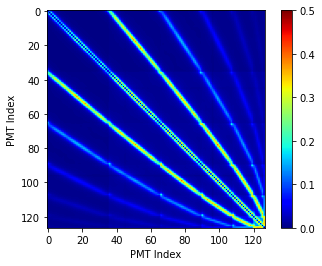

In [19]:
fig = plt.figure()
ax= fig.subplots()
plt.imshow(adjacency_m, cmap='jet',vmin=0,vmax=0.5)
plt.colorbar()
ax.set_ylabel('PMT Index')
ax.set_xlabel('PMT Index')
limits=plt.axis('on')
plt.show()